## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from tempfile import mkdtemp
from shutil import rmtree

from xgboost import XGBRegressor

from sklearn import set_config
set_config(display = 'diagram')

# Sklearn preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, VarianceThreshold, SelectFromModel
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor


/home/matias/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Loading Data

In [2]:
# You can use this direct download link if you don't want to create a Kaggle account
data = pd.read_csv('https://wagon-public-datasets.s3.amazonaws.com/houses_train_raw.csv', index_col='Id')
data.head()


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
X = data.drop(columns=['SalePrice'])
y = data.SalePrice

X.shape, y.shape


((1460, 79), (1460,))

## 1 - Baseline Model

In [ ]:
X.dtypes.value_counts()


object     43
int64      33
float64     3
dtype: int64

### 1.1 Initial feature overview: Categorical Variables

In [5]:
feat_categorical_nunique = X.select_dtypes(include='object').nunique()


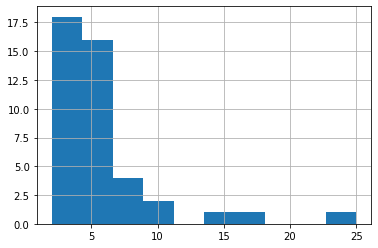

In [ ]:
feat_categorical_nunique.hist();


- We will remove all teh features with 7 values or more
- We will One Hot Encode the rest

In [6]:
# categorical features to one-hot-encode
feat_categorical_small = list(feat_categorical_nunique[feat_categorical_nunique < 7].index)


In [7]:
len(feat_categorical_small)


34

### 1.2 Baseline Pipe

In [8]:
preproc_numerical_baseline = make_pipeline(
    SimpleImputer(),
    MinMaxScaler()
)

preproc_categorical_baseline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

preproc_baseline = make_column_transformer(
    (preproc_numerical_baseline, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_categorical_baseline, feat_categorical_small),
    remainder="drop"
)

preproc_baseline


ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f082dd204f0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ign...
                                 ['MSZoning', 'Street', 'Alley', 'LotShape',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'BldgType', 'RoofStyle',
                                  'MasVnrType', 'ExterQual', 'ExterCond',
                                  'Foundation', 'BsmtQual', 'BsmtCond',
                                  'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', 'KitchenQual',
                                  'FireplaceQu', 'GarageType', 'GarageFinish',
                                  'GarageQual', 'GarageCond', 'PavedDrive', ...])])

In [9]:
shape_preproc_baseline = preproc_baseline.fit_transform(X).shape
shape_preproc_baseline


(1460, 183)

In [10]:
pipe_baseline = make_pipeline(preproc_baseline, DecisionTreeRegressor())
pipe_baseline


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f082dd204f0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencod...
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...])])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

#### Kaggle House Competition is calcultaed with RMSLE

RMSLE formula

$$\text{RMSLE}(y, \hat{y}) = \sqrt{\frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (\log_e (1 + y_i) - \log_e (1 + \hat{y}_i) )^2.}$$

In [11]:
# This is our metric to minimize
rmsle = make_scorer(lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5)

# This is our score to maximize
rmsle_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_log_error(y_true, y_pred)**0.5)


### 1.3 Baseline Socre

In [12]:
score_baseline = cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle).mean()
score_baseline


0.21297064199429663

### 1.4 Baseline Prediction

In [13]:
X_test = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/houses_test_raw.csv")
X_test_ids = X_test['Id'] # Keep ids
X_test = X_test.drop(columns=['Id'])

# Predict y_pred_baseline
pipe_baseline.fit(X,y)
y_pred_baseline = pipe_baseline.predict(X_test)
y_pred_baseline


array([129000., 157000., 210000., ..., 142500.,  93500., 205000.])

In [14]:
results = pd.concat([X_test_ids, pd.Series(y_pred_baseline, name="SalePrice")], axis=1)
results.head(1)


,Id,SalePrice
0,1461,129000.0


In [15]:
# Export to Kaggle format submission in the `data` folder
results.to_csv("data/submission_baseline.csv", header=True, index=False)


# 2. Real Model

## 2.1 Preprocessing 

### 2.1.1 Ordinal Encoding

In [17]:
feat_ordinal_dict = {
    # Considers "missing" as "neutral"
    "BsmtCond": ['missing', 'Po', 'Fa', 'TA', 'Gd'],
    "BsmtExposure": ['missing', 'No', 'Mn', 'Av', 'Gd'],
    "BsmtFinType1": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtFinType2": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Electrical": ['missing', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    "ExterCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "ExterQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Fence": ['missing', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
    "FireplaceQu": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "Functional": ['missing', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    "GarageCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "GarageFinish": ['missing', 'Unf', 'RFn', 'Fin'],
    "GarageQual": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "HeatingQC": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "KitchenQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "LandContour": ['missing', 'Low', 'Bnk', 'HLS', 'Lvl'],
    "LandSlope": ['missing', 'Sev', 'Mod', 'Gtl'],
    "LotShape": ['missing', 'IR3', 'IR2', 'IR1', 'Reg'],
    "PavedDrive": ['missing', 'N', 'P', 'Y'],
    "PoolQC": ['missing', 'Fa', 'Gd', 'Ex']
}

feat_ordinal = sorted(feat_ordinal_dict.keys()) # sort alphabetically
feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal]

encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than "missing"
)

preproc_ordinal = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    encoder_ordinal,
    MinMaxScaler()
)

preproc_ordinal


Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['missing', 'Po', 'Fa', 'TA', 'Gd'],
                                            ['missing', 'No', 'Mn', 'Av', 'Gd'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Mix', 'FuseP...
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Low', 'Bnk', 'HLS',
                                             'Lvl'],
                                            ['missing', 'Sev', 'Mod', 'Gtl'],
                                            ['missing', 'IR3', 'IR2', 'IR1',
                                             'Reg'],
                                            ['missing', 'N', 'P', 'Y'],
                                            ['missing', 'Fa', 'Gd', 'Ex']],
                                dtype=<class 'numpy.int64'>,
                                handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('minmaxscaler', MinMaxScaler())])

In [18]:
# Define numerical feature once-for-all
feat_numerical = sorted(X.select_dtypes(include=["int64", "float64"]).columns)

preproc_numerical = make_pipeline(
    KNNImputer(),
    MinMaxScaler()
)


In [19]:
# Define nominal features to one-hot-encode as the remaining ones (non-numerical, non-ordinal)
feat_nominal = sorted(list(set(X.columns) - set(feat_numerical) - set(feat_ordinal)))

preproc_nominal = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)


In [20]:
preproc = make_column_transformer(
    (preproc_numerical, feat_numerical),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop"
)

preproc


ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['1stFlrSF', '2ndFlrSF', '3SsnPorch',
                                  'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2',
                                  'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
                                  'EnclosedPorch', 'Fireplaces', 'FullBath',
                                  'GarageArea', 'GarageCars', 'GarageYrBlt',
                                  'GrLivArea', 'HalfBath', 'Kitc...
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Alley', 'BldgType', 'CentralAir',
                                  'Condition1', 'Condition2', 'Exterior1st',
                                  'Exterior2nd', 'Foundation', 'GarageType',
                                  'Heating', 'HouseStyle', 'LotConfig',
                                  'MSZoning', 'MasVnrType', 'MiscFeature',
                                  'Neighborhood', 'RoofMatl', 'RoofStyle',
                                  'SaleCondition', 'SaleType', 'Street',
                                  'Utilities'])])

In [21]:
pd.DataFrame(preproc.fit_transform(X,y)).head()


,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,0.119780,0.413559,0.0,0.375,0.125089,0.0,0.333333,0.0,0.064212,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.212942,0.000000,0.0,0.375,0.173281,0.0,0.000000,0.5,0.121575,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,0.134465,0.419370,0.0,0.375,0.086109,0.0,0.333333,0.0,0.185788,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,0.143873,0.366102,0.0,0.375,0.038271,0.0,0.333333,0.0,0.231164,0.492754,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,0.186095,0.509927,0.0,0.500,0.116052,0.0,0.333333,0.0,0.209760,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


### 2.1.2 Statistical Feature Selection

#### Option 1 - Univariate Feature Selection
*based on their mutual information with target `y`*

In [22]:
preproc_transformer = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop"
)

preproc_selector = SelectPercentile(
    mutual_info_regression,
    percentile=25, # keep only 25% of all features
)

preproc = make_pipeline(
    preproc_transformer,
    preproc_selector
)

preproc


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f082dca0df0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('o...
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=25,
                                  score_func=<function mutual_info_regression at 0x7f086826c040>))])

In [23]:
preproc.fit_transform(X, y).shape


(1460, 54)

#### Option 2 Multivariate Feature Selection
*based on their combined relationship with target `y`*

In [24]:
preproc_transformer_multi = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop"
)

preproc_selector_multi = SelectFromModel(
    RandomForestRegressor(),
    threshold = "median", # drop all multivariate features lower than the median correlation
)

preproc_multi = make_pipeline(
    preproc_transformer_multi,
    preproc_selector_multi
)

preproc_multi


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f082dca2d10>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('o...
                                                  ['Alley', 'BldgType',
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])])),
                ('selectfrommodel',
                 SelectFromModel(estimator=RandomForestRegressor(),
                                 threshold='median'))])

### 2.1.3 Treat Cyclical Features

In [25]:
# Treat cyclical features
months_in_a_year = 12

X['sin_MoSold'] = np.sin(2 * np.pi * (X.MoSold - 1) / months_in_a_year)
X['cos_MoSold'] = np.cos(2 * np.pi * (X.MoSold - 1) / months_in_a_year)

X.drop(columns=['MoSold'], inplace=True)

X.head()


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,YrSold,SaleType,SaleCondition,sin_MoSold,cos_MoSold
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2008,WD,Normal,0.500000,0.866025
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,2007,WD,Normal,0.866025,-0.500000
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2008,WD,Normal,-0.866025,-0.500000
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2006,WD,Abnorml,0.500000,0.866025
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,2008,WD,Normal,-0.500000,0.866025


### 2.1.4 Target Engineering

- We are asked to minimize the RMSLE. 
- Transform our target to directly predict that

Text(0.5, 0, 'log(SalePrice)')

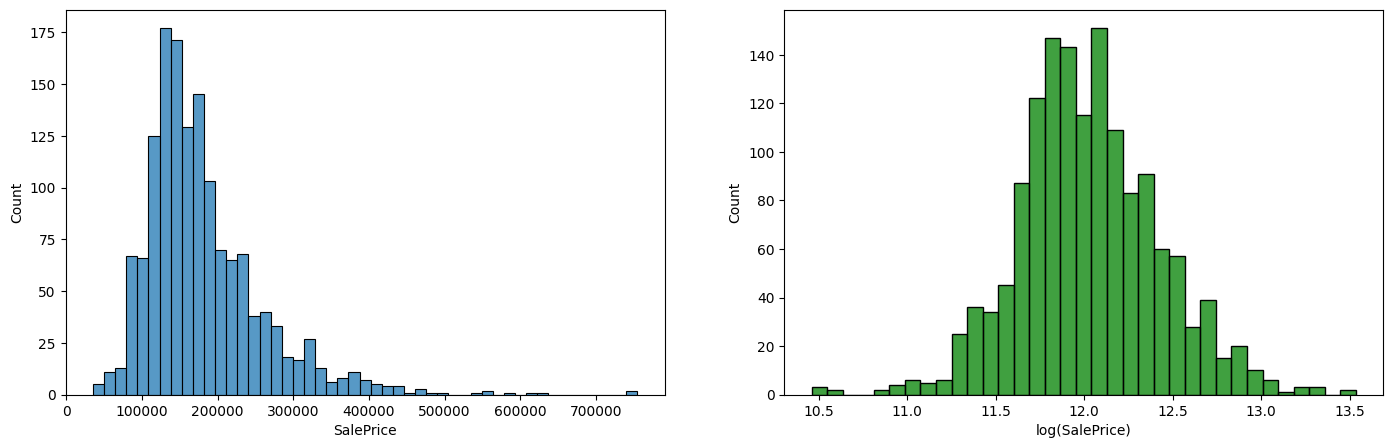

In [26]:
y_log = np.log(y)

plt.figure(figsize=(17, 5))

plt.subplot(1, 2, 1)
sns.histplot(y)

plt.subplot(1, 2, 2)
sns.histplot(y_log, color='green')

plt.xlabel("log(SalePrice)")


In [27]:
# Create your new scorer to minimize
rmse = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred)**0.5)

# Create your new scorer to maximize
rmse_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_error(y_true, y_pred)**0.5)


## 2.2 Model Pipeline

In [28]:
encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than "missing"
)

preproc_ordinal = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    encoder_ordinal,
    MinMaxScaler()
)

preproc_numerical = make_pipeline(
    KNNImputer(),
    MinMaxScaler()
)

preproc_transformer = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop"
)

preproc_selector = SelectPercentile(
    mutual_info_regression,
    percentile=50, # keep only xx% of all features )
)
preproc = make_pipeline(
    preproc_transformer,
    preproc_selector
)

preproc


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f082ba04190>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('o...
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=50,
                                  score_func=<function mutual_info_regression at 0x7f086826c040>))])

In [29]:
# Check shape
preproc_fitted = preproc.fit(X,y)
preproc_fitted_log = preproc.fit(X,y_log)

preproc_fitted_log.transform(X).shape


(1460, 108)

## 2.3 Model Selection

In [30]:
allow_grid_searching = True # Use True to activate GridSearch in the notebook cells below

# Cache the preprocessing step of the pipeline
cachedir = mkdtemp()


#### 2.3.1 Linear Models (Lasso, Ridge, ElasticNet, SGDRegressor, etc.)

In [31]:
# Ridge with normal target
model = Ridge()

pipe_ridge = make_pipeline(preproc, model, memory=cachedir)

cross_val_score(pipe_ridge, X, y, cv=5, scoring=rmsle).mean()


/home/matias/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/pipeline.py:377: UserWarning: Persisting input arguments took 0.72s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


0.17196730691336598

In [32]:
# Ridge with log-target (much better)
model = Ridge()

pipe_ridge = make_pipeline(preproc, model, memory=cachedir)

cross_val_score(pipe_ridge, X, y_log, cv=5, scoring=rmse).mean()


0.14011799161328856

In [33]:
# GridSearch the Ridge regularization
if allow_grid_searching:
    param_grid =  {'ridge__alpha': np.linspace(0.5, 2, num=20)}

    search_ridge = GridSearchCV(
        pipe_ridge,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        verbose=2,
        scoring=rmse_neg
    )

    search_ridge.fit(X, y_log);

    print('\n----------------------------------------\n')
    print(f'Best params 👉 {search_ridge.best_params_}')
    print(f'Best score 👉 {search_ridge.best_score_}')


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/matias/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/matias/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/matias/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/matias/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17

[CV] END ...................................ridge__alpha=0.5; total time=   1.0s
[CV] END ...................................ridge__alpha=0.5; total time=   1.1s
[CV] END ...................................ridge__alpha=0.5; total time=   1.2s
[CV] END ...................................ridge__alpha=0.5; total time=   1.1s
[CV] END ...................................ridge__alpha=0.5; total time=   0.7s
[CV] END ....................ridge__alpha=0.5789473684210527; total time=   0.7s
[CV] END ....................ridge__alpha=0.5789473684210527; total time=   0.7s
[CV] END ....................ridge__alpha=0.5789473684210527; total time=   0.9s
[CV] END ....................ridge__alpha=0.5789473684210527; total time=   1.0s
[CV] END ....................ridge__alpha=0.5789473684210527; total time=   1.1s
[CV] END ....................ridge__alpha=0.6578947368421053; total time=   1.0s
[CV] END ....................ridge__alpha=0.6578947368421053; total time=   1.2s
[CV] END ...................

#### 2.3.2 SVM

In [37]:
model = SVR(kernel='linear')

pipe_svm = make_pipeline(preproc, model, memory=cachedir)

cross_val_score(pipe_svm, X, y_log, cv=5, scoring=rmse).mean()


0.13767660471690188

In [38]:
model = SVR(kernel='rbf', C = 10)

pipe_svm_rbf = make_pipeline(preproc, model, memory=cachedir)

cross_val_score(pipe_svm_rbf, X, y_log, cv=5, scoring=rmse).mean()


0.1363127838231038

In [39]:
# GridSearch
if allow_grid_searching:
    param_grid =  {
        'svr__C': [0.5, 0.7, 1, 2, 5, 10],
        'svr__epsilon': [0.01, 0.05, 0.1, 0.2, 0.5],
        #'svr__coef0': [0.0, 0.1, 0.5,1],
    }

    search_svm_rbf = GridSearchCV(
        pipe_svm_rbf,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        verbose=2,
        scoring=rmse_neg
    )

    search_svm_rbf.fit(X, y_log);

    svm_rbf_best = search_svm_rbf.best_estimator_

    print('\n----------------------------------------\n')
    print(f'Best params 👉 {search_svm_rbf.best_params_}')
    print(f'Best score 👉 {search_svm_rbf.best_score_}')


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END ......................svr__C=0.5, svr__epsilon=0.01; total time=   0.9s
[CV] END ......................svr__C=0.5, svr__epsilon=0.01; total time=   1.0s
[CV] END ......................svr__C=0.5, svr__epsilon=0.01; total time=   1.0s
[CV] END ......................svr__C=0.5, svr__epsilon=0.01; total time=   1.1s
[CV] END ......................svr__C=0.5, svr__epsilon=0.05; total time=   0.9s
[CV] END ......................svr__C=0.5, svr__epsilon=0.05; total time=   0.9s
[CV] END ......................svr__C=0.5, svr__epsilon=0.01; total time=   1.0s
[CV] END ......................svr__C=0.5, svr__epsilon=0.05; total time=   1.0s
[CV] END .......................svr__C=0.5, svr__epsilon=0.1; total time=   1.3s
[CV] END ......................svr__C=0.5, svr__epsilon=0.05; total time=   1.4s
[CV] END .......................svr__C=0.5, svr__epsilon=0.1; total time=   1.3s
[CV] END ......................svr__C=0.5, svr_

#### 2.3.4 Trees

In [40]:
model = DecisionTreeRegressor(max_depth=50, min_samples_leaf=20)

pipe = make_pipeline(preproc, model, memory=cachedir)

score = cross_val_score(pipe, X, y_log, cv=5, scoring=rmse)

print(score.std())
print(score.mean())


0.010026893027705737
0.18889941289621864


- Random Forest

In [41]:
# TODO: GridSearch

model = RandomForestRegressor(max_depth=50,min_samples_leaf=20)

pipe = make_pipeline(preproc, model, memory=cachedir)

score = cross_val_score(pipe, X, y_log, cv=5, scoring=rmse)

print(score.std())
print(score.mean())


0.007743037722687574
0.16330677657401088


- Boosted Trees

In [42]:
model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None))

pipe = make_pipeline(preproc, model, memory=cachedir)

score = cross_val_score(pipe, X, y_log, cv=5, scoring=rmse)

print(score.std())
print(score.mean())


/home/matias/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/matias/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/matias/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/matias/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/matias/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/en

0.01042148396546894
0.1429127895189834


In [43]:
model = GradientBoostingRegressor(n_estimators=100, verbose=0)

pipe_gb = make_pipeline(preproc, model, memory=cachedir)

score = cross_val_score(pipe_gb, X, y_log, cv=5, scoring=rmse)

print(score.std())
print(score.mean())


0.009853317976733758
0.12720623488980695


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END gradientboostingregressor__max_features=47, gradientboostingregressor__n_estimators=205; total time=   1.2s
[CV] END gradientboostingregressor__max_features=47, gradientboostingregressor__n_estimators=205; total time=   1.3s
[CV] END gradientboostingregressor__max_features=47, gradientboostingregressor__n_estimators=205; total time=   1.0s
[CV] END gradientboostingregressor__max_features=47, gradientboostingregressor__n_estimators=205; total time=   1.3s
[CV] END gradientboostingregressor__max_features=47, gradientboostingregressor__n_estimators=205; total time=   1.2s
[CV] END gradientboostingregressor__max_features=9, gradientboostingregressor__n_estimators=114; total time=   0.5s
[CV] END gradientboostingregressor__max_features=9, gradientboostingregressor__n_estimators=114; total time=   0.4s
[CV] END gradientboostingregressor__max_features=9, gradientboostingregressor__n_estimators=114; total time=   0.4s
[CV] EN

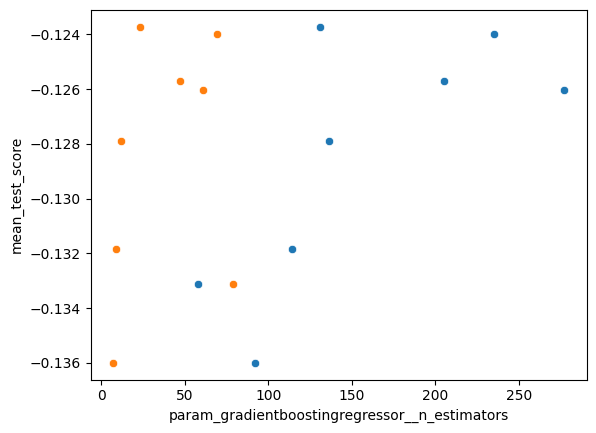

In [44]:
if allow_grid_searching:
     grid = {
          'gradientboostingregressor__n_estimators': stats.randint(50,300),
          # 'gradientboostingregressor__learning_rate': stats.uniform(0.05, 0.3),
          # 'gradientboostingregressor__loss': ['lad', 'huber', 'quantile'],
          # 'gradientboostingregressor__max_depth': stats.randint(3, 5),
          # 'gradientboostingregressor__min_samples_split': stats.randint(2, 10),
          # 'gradientboostingregressor__subsample': [0.95, 1], # 1 default
          'gradientboostingregressor__max_features': stats.randint(0.9, len(X.columns)) # default None, i.e = n_features
     }

     search_gb = RandomizedSearchCV(pipe_gb, grid, scoring=rmse_neg, n_iter=8, cv=5, n_jobs=1, verbose=2)

     # Fit data to GridSearch
     search_gb.fit(X, y_log);

     print('\n----------------------------------------\n')
     print(f'Best params 👉 {search_gb.best_params_}')
     print(f'Best score 👉 {search_gb.best_score_}')

     # Plot results of GridSearch
     df_cv_results_ = pd.DataFrame(search_gb.cv_results_)

     sns.scatterplot(x="param_gradientboostingregressor__n_estimators", y='mean_test_score', data=df_cv_results_)
     sns.scatterplot(x="param_gradientboostingregressor__max_features", y='mean_test_score', data=df_cv_results_)


## 2.4 Complex Models

#### 2.4.1 Stacking

In [47]:
gboost = GradientBoostingRegressor(n_estimators=100)
ridge = Ridge()
svm = SVR(C=1, epsilon=0.05)
adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None))


model = VotingRegressor(
    estimators = [("gboost", gboost), ("adaboost", adaboost), ("ridge", ridge), ("svm_rbf", svm)],
    weights = [1, 1, 1, 1], # to equally weight the models
    n_jobs=-1
)

pipe_ensemble = make_pipeline(preproc, model, memory=cachedir)

score = cross_val_score(pipe_ensemble, X, y_log, cv=5, scoring=rmse, n_jobs=-1)

print(score.std())
print(score.mean())


/home/matias/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/matias/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/matias/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/matias/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/matias/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/en

0.010465886407606543
0.12260809582583307


In [45]:
gboost = GradientBoostingRegressor(n_estimators=100)
ridge = Ridge()
svm = SVR(C=1, epsilon=0.05)
adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None))

model = StackingRegressor(
    estimators=[("gboost", gboost), ("adaboost", adaboost), ("ridge", ridge), ("svm_rbf", svm)],
    final_estimator=LinearRegression(),
    cv=5,
    n_jobs=-1
)

pipe_stacking = make_pipeline(preproc, model, memory=cachedir)

score = cross_val_score(pipe_stacking, X, y_log, cv=5, scoring=rmse, n_jobs=-1)

print(score.std())
print(score.mean())


/home/matias/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/matias/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/matias/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/matias/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/matias/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/en

0.010873289036002955
0.12176357600335419


#### 2.4.2 XGBoost

In [46]:
X_train, X_eval, y_train_log, y_eval_log = train_test_split(X, y_log, random_state=42)


In [48]:
# Instantiate model
model_xgb = XGBRegressor(max_depth=10, n_estimators=300, learning_rate=0.1)


In [49]:
pipe_xgb = make_pipeline(preproc, model_xgb)

cross_val_score(pipe_xgb, X, y_log, cv=5, scoring=rmse, n_jobs=-1).mean()


0.13172864756847358

# 3 SUBMISSION

In [51]:
X_test = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/houses_test_raw.csv")

X_test_ids = X_test['Id'] # Keep ids
X_test = X_test.drop(columns=['Id'])


In [52]:
# Adding columns to X_test according to what we did to X
X_test['sin_MoSold'] = np.sin(2 * np.pi * (X_test.MoSold - 1) / months_in_a_year)
X_test['cos_MoSold'] = np.cos(2 * np.pi * (X_test.MoSold - 1) / months_in_a_year)

X_test.drop(columns=['MoSold'], inplace=True)


In [53]:
pipe_stacking.fit(X, y_log)

predictions_log = pipe_stacking.predict(X_test)
predictions = np.exp(predictions_log)


/home/matias/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/matias/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/matias/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/matias/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17

In [54]:
results = pd.concat([X_test_ids, pd.Series(predictions, name="SalePrice")], axis=1)
results


,Id,SalePrice
0,1461,119228.109345
1,1462,153866.294229
2,1463,179665.008558
3,1464,189614.962060
4,1465,196119.607689
...,...,...
1454,2915,78053.366485
1455,2916,79913.692406
1456,2917,163236.568440
1457,2918,109597.132432


In [55]:
results.to_csv("submission_final.csv", header=True, index=False)


In [56]:
# Clear the cache directory at the end
rmtree(cachedir)
